In [14]:

list.of.packages = c('tidyverse', 'gridExtra','ggplot2')
new.packages = 
list.of.packages[!(list.of.packages 
                   %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, 
                     repos='http://cran.us.r-project.org')
    
suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(gridExtra, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(ggplot2, quietly = TRUE, warn.conflicts = FALSE))


set.seed(271828)


In this module you will see how cross-validation is implemented and how it can be used to choose the functional form for a polynomial regression.

Lets generate data from a fourth order polynomial: $y=\beta_0+\beta_1x+\beta_2x^2+\beta_3x^3+\beta_4x^4+\varepsilon$



In [15]:

N = 1500                                       
# Sample size
beta = matrix(c(.2,-.01,.3,-.005))            
# coefficient vector
x0 = array(1,c(N,1))                          
#intercept is separate             
x1 = c(runif(N,-2,2))                         
# generate N uniform rvs between -2,2
x2 = x1^2                                    
# squared                         
x3 = x1^3                                    
# cubed                  
x4 = x1^4                                    
# 4th power                     
X = cbind(x1,x2,x3,x4)                       
# X is the concatenation of 4 column vectors              
y = x0+X%*%beta + c(rnorm(N)*1.5)           
# y is generated from a 4th order polynomial with N(0,2.25) errors   
Xvar = data.frame(cbind(y,x1))               
# creates a data frame from the "observed" covariates y and x 
colnames(Xvar) = c('y', 'X')                   
# label the columns of the dataframe     


In practice we don't know the order of the polynomial. We only observe observations from $y$ and $x$.

We can visualize the data to examine the relationship.

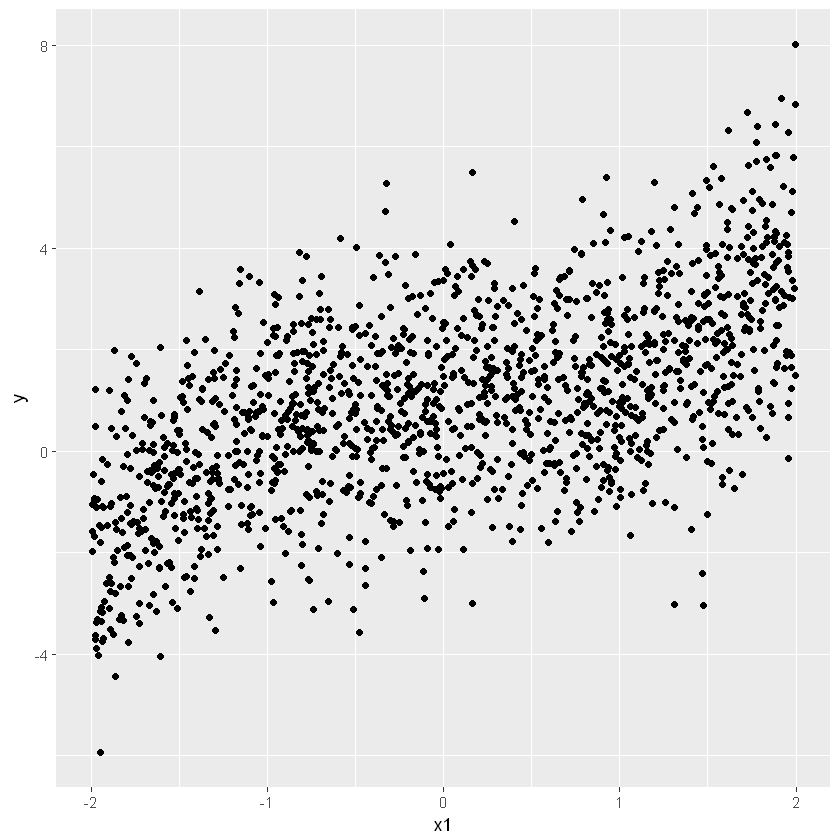

In [16]:
qplot(x1,y)                         
# ggplot looks nicer than built in plotting in R (qplot stands for quick plot)

Our visualization suggests the relationship is nonlinear, but we need some way of determining the order of the polynomial. Enter cross-validation!

Since we are doing data driven model selection we first want to split our data so that we have a validation sample. Let's go ahead and take $10\%$ of the sample for validation.

If your data has particular structure (panel, clustering, etc) you want to be careful about how you split/shuffle the data. In this case we know the structure and it will be ok to just slice off a random subsample.



In [17]:
#Splitting the data

data_split = function(data,split=.1){

    N = dim(data)[1]                         
    random = sample(1:N,N,replace=F)          
    # Randomly choose the index for the splits
    data = data[random,]                      
    # Shuffle data
    test = data[1:round(N*split),]           
    # Splits
    train = data[(round(N*split)+1):N,]

    
    return(list(train,test))
}


tmp = data_split(Xvar) 
train_test = tmp[[1]]
validation = tmp[[2]]


OK now that we have our data split we can start the cross-validation proceedure.

First we need to choose $P$, the number of models we are considering. We also need to choose the number of folds $k$.

Let's go ahead and look at $p={1,2,\dots,8}$ and $k=5$.

Model 1 will be $y=\beta_0+\beta_1 x+\varepsilon$.

There are many packages that implement cross-validation in R. We will use a few of these in later modules, but just so you can see what is happening under the hood this is a direct implementation.

In [18]:


num_folds = 5                                          
# Number of folds
N = dim(train_test)[1]                                 
# Number of observations
p = dim(train_test)[2]                                 
# Number of covariates
sel = diag(num_folds)                                  
# One way of selecting train/test splits is through basis vectors
size = round(dim(train_test)[1]/num_folds)             
# The size of each 
train = array(,dim=c(size*(num_folds-1),p,num_folds))  
# 3d matrix to store training data for each iteration
test = array(,dim=c(size,p,num_folds))                 
# 3d matrix to store test data for each iteration
MSE = array(,c(num_folds))                             
# 2d matrix to store MSE evaluated on the test data   
yhat = array(,c(N,num_folds))

for (i in 1:num_folds){                                    
    # This block just assigns train/test to 
    # each fold there are many ways to accomplish this

    test[,,i] = as.matrix(train_test)[
        as.logical(kronecker(array(1,c(size,1)),sel[i,])),]
    train[,,i] = as.matrix(train_test)[
        as.logical(kronecker(array(1,c(size,1)),(1-sel[i,]))),]
    train_tmp = data.frame(train[,,i])
    test_tmp = data.frame(test[,,i])
    X_train = as.data.frame(train_tmp[,2:p])
    X_test = as.data.frame(test_tmp[,2:p])
    colnames(X_test) = colnames(X_train)

    # Once we have our train/test folds we want to estimate the
    # model on the training set and predict on the test
    
    yhat[,i] = predict(lm(train_tmp[,1]~.,data = X_train),newdata=X_test)                                   

    MSE[i] = mean((test_tmp[,1]-yhat[,i])^2)          
    # output the MSE evaluated on the test data
                          
}

cat('MSE evaluated on each test fold:', MSE)

MSE evaluated on each test fold: 2.110355 2.336571 2.625581 2.175373 2.260462

For each fold we have a MSE. To get a general idea of the out-of-sample performance of our model we can take the mean of these values.


In [19]:
mean(MSE)

[1] 2.301668

We can visualize what we've done by looking at a colored scatter plot. The blue dots are the observations we used as training data in that particular iteration, the red dots refer to the test observations.

The black line is the fitted line based on the test data

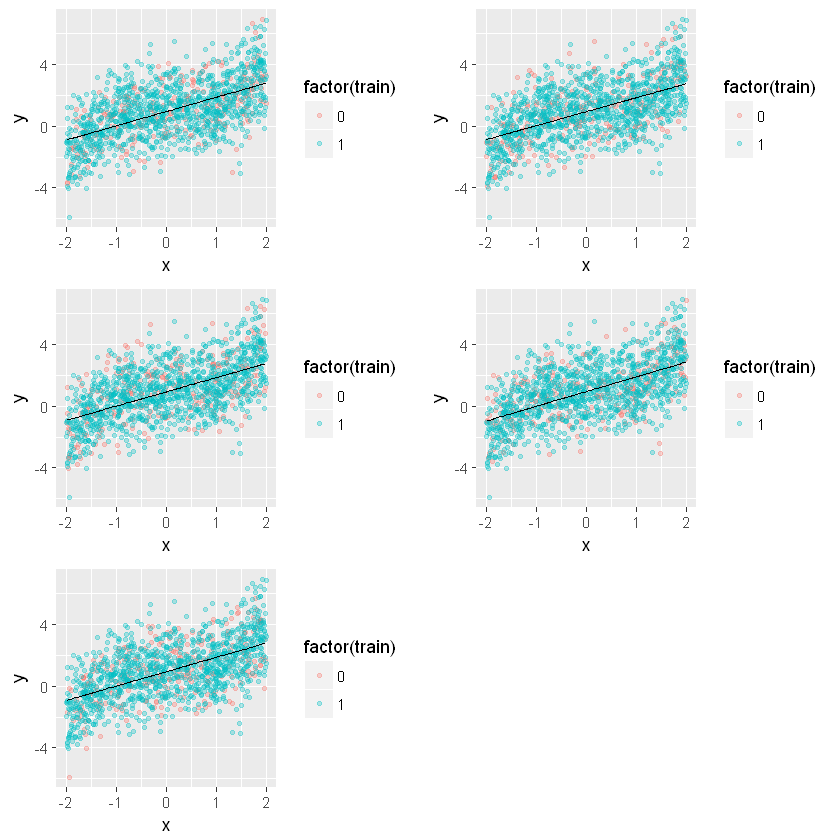

In [20]:
for (i in 1:5){
    visual = data.frame(cbind(rbind(test[,,i],train[,,i]),
                              as.logical(rbind(array(0,c(size,1)),
                               array(1,c((num_folds-1)*size,1))))))
    
    colnames(visual) = c('y','x','train')
    pred = data.frame(cbind(yhat[,i],test[,2,i]))
    colnames(pred) = c('ytest','xtest')

    assign(paste('p',i,sep=''), ggplot(visual , aes(x = x, y = y)) +
           geom_point(aes(color = factor(train)),alpha=.3,size=1) +
           geom_line(data=pred, aes(x=xtest,y=ytest)))
}

grid.arrange(p1,p2,p3,p4,p5,ncol=2)

Now that we've seen how this works, let's go ahead and estimate the remaining models.

In [21]:
# Wrapping our previous code into a function

CV_linear = function(train_test,num_folds){
    N = dim(train_test)[1]                                 
    # Number of observations
    p = dim(train_test)[2]                                 
    # Number of covariates
    sel = diag(num_folds)                                  
    # One way of selecting train/test splits is through basis vectors
    size = round(dim(train_test)[1]/num_folds)             
    # The size of each 
    train = array(,dim=c(size*(num_folds-1),p,num_folds))  
    # 3d matrix to store training data for each iteration
    test = array(,dim=c(size,p,num_folds))                 
    # 3d matrix to store test data for each iteration
    MSE = array(,c(num_folds))                             
    # 2d matrix to store MSE evaluated on the test data
    yhat = array(,c(N,num_folds))

    for (i in 1:num_folds){                                  
        # This block just assigns train/test to each fold

        test[,,i] = as.matrix(train_test)[
            as.logical(kronecker(array(1,c(size,1)),sel[i,])),]
        train[,,i] = as.matrix(train_test)[
            as.logical(kronecker(array(1,c(size,1)),(1-sel[i,]))),]
        train_tmp = data.frame(train[,,i])
        test_tmp = data.frame(test[,,i])
        X_train = as.data.frame(train_tmp[,2:p])
        X_test = as.data.frame(test_tmp[,2:p])
        colnames(X_test) = colnames(X_train)
        
        # Once we have our train/test folds we want to estimate 
        # the model on the training set and predict on the test

        yhat[,i] = predict(lm(train_tmp[,1]~.,data = X_train),newdata=X_test) 
                                                                             
        MSE[i] = mean((test_tmp[,1]-yhat[,i])^2)            
        # output the MSE evaluated on the test data
                 
        }
      return(MSE)
}


models = function(train_test,num_folds){
    mse = array(,c(8,num_folds))
    for (i in seq(1,8,1)){                                                     
        # Iterate through the models and get CV estimates
        if (i>1){
          train_test[paste('X',i,sep="")] = train_test[,1]^i
          mse[i,] = CV_linear(train_test,num_folds)
          } else{
          mse[i,] = CV_linear(train_test,num_folds)
          }

        }
    return(mse)
}

mse = models(train_test,5)

We've performed 5-fold cross validation on all $8$ of our models! Let's see which one performed best.

In [22]:
model.names = NULL
for (i in 1:8){
    model.names[i] = paste('model',i,sep='')
    }
CV_mse = data.frame(mse,row.names=model.names)
colnames(CV_mse) = seq(1,5,1)

In [23]:
CV_mse

cat('5-fold CV picks: Model', which.min(rowMeans(CV_mse))[1])

,1,2,3,4,5
model1,2.1103550,2.3365711,2.6255808,2.1753726,2.260462
model2,1.4853390,1.5325206,1.8435377,1.5494922,1.753265
model3,1.3021754,1.1727235,1.3618054,1.1656409,1.143186
model4,0.6961988,0.7382483,0.7856073,0.7293523,3.039271
model5,0.7282898,0.6140313,0.6486415,0.6651043,3.833308
model6,0.4062562,0.4281261,0.4434341,0.3800618,14.756410
model7,0.4547821,0.4123957,0.4047970,0.3864900,83.640426
model8,0.2416564,0.2227162,0.2446381,0.2258842,31.109392


5-fold CV picks: Model 4

That's pretty cool. Cross validation picked the right model!

Will this always happen? No, but as long as the proceedure is done properly, we will choose the right model most of the time!

Now that we've chosen the model we can go ahead and estimate our model with the validation data and see how we do.

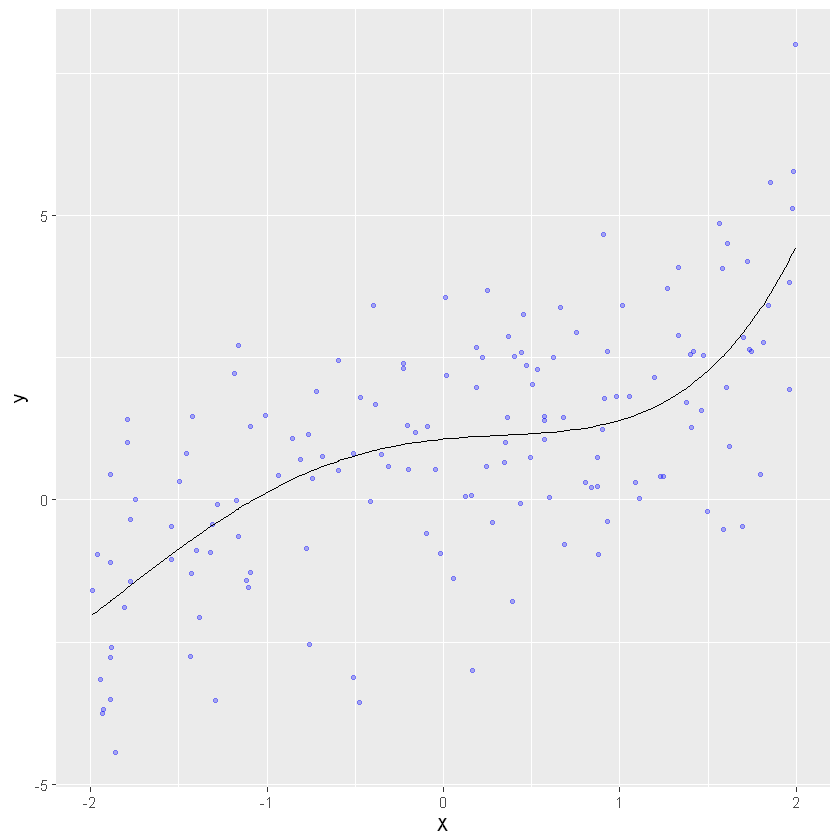

In [24]:
validation['X2'] = (validation$X)^2
validation['X3'] = (validation$X)^3
validation['X4'] = (validation$X)^4

X = validation[,2:5]
y = validation[,1]


OLS = lm(y~.,data = X)

pred = predict(OLS)
pred = cbind(X,pred)

ggplot(validation , aes(x = X, y = y)) +
           geom_point(color = 'blue',alpha=.3,size=1) +
           geom_line(data=pred, aes(x=X,y=pred))

EXERCISE:

Rerun the exercise with 10-fold cross validation. Does the proceedure still pick the right model?
